In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.5

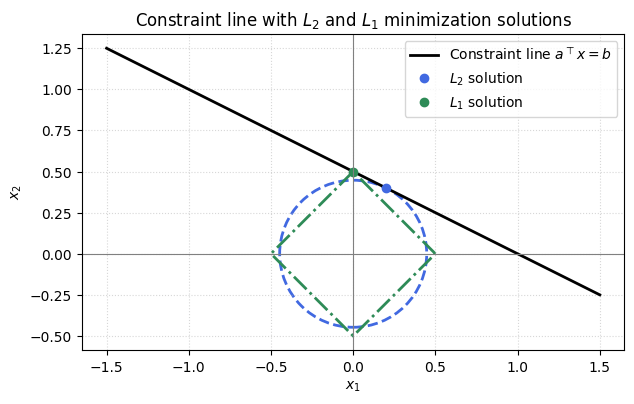

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Polygon

# Constraint: a^T x = b with a = [1,2], b = 1
a = np.array([1.0, 2.0])
b = 1.0

# L2 solution: projection of origin onto the line
a_norm2 = np.dot(a, a)
x2 = (b / a_norm2) * a  # (1/5, 2/5)
r2 = np.linalg.norm(x2)

# L1 solution: check axis-aligned candidates
x_candidates = [np.array([1.0, 0.0]), np.array([0.0, 0.5])]
l1_values = [np.sum(np.abs(xc)) for xc in x_candidates]
x1 = x_candidates[np.argmin(l1_values)]  # (0, 0.5)
t1 = np.sum(np.abs(x1))

# Plot
fig, ax = plt.subplots(figsize=(7,7))

# Constraint line: x + 2y = 1 -> y = (1 - x)/2
x_line = np.linspace(-1.5, 1.5, 400)
y_line = (b - a[0]*x_line)/a[1]
ax.plot(x_line, y_line, color='black', lw=2, label=r'Constraint line $a^\top x = b$')

# L2 circle (no label)
circle = Circle((0,0), r2, edgecolor='royalblue', facecolor='none', lw=2, linestyle='--')
ax.add_patch(circle)

# L1 diamond (no label)
diamond_vertices = np.array([[ t1, 0],
                             [ 0, t1],
                             [-t1, 0],
                             [ 0,-t1]])
diamond = Polygon(diamond_vertices, closed=True, edgecolor='seagreen', facecolor='none', lw=2, linestyle='-.')
ax.add_patch(diamond)

# Solutions
ax.plot(x2[0], x2[1], 'o', color='royalblue', label=r'$L_2$ solution')
ax.plot(x1[0], x1[1], 'o', color='seagreen', label=r'$L_1$ solution')

# Styling
ax.axhline(0, color='gray', lw=0.8)
ax.axvline(0, color='gray', lw=0.8)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_title(r'Constraint line with $L_2$ and $L_1$ minimization solutions')
ax.set_aspect('equal', 'box')
ax.legend(loc='upper right')
ax.grid(True, linestyle=':', alpha=0.5)

plt.show()